# **Oxford Flowers Clustering Notebook**

In this notebook, we:
1. Load the validation and test splits of the Oxford Flower Dataset, merging them.
2. Compute (or load) the VLAD vectors from the deep extractor.
3. Cluster these images into 102 clusters (the number of classes).
4. Compute ARI, NMI, and interpret the results.

---

## **1. Setup and Load Data**


In [8]:
from torchvision.models import vgg16, VGG16_Weights

from pyvisim.datasets import OxfordFlowerDataset
from pyvisim._utils import *
from pyvisim.features import DeepConvFeature
from pyvisim.encoders import VLADEncoder, KMeansWeights
from pyvisim._config import ROOT

# Load the validation and test datasets.

In [9]:
dataset = OxfordFlowerDataset(purpose=["validation", "test"])
print("Number of images in the dataset:", len(dataset))

Number of images in the dataset: 2040


## **2. Compute VLAD vectors**


#### Define the feature extractor and the VLAD encoder**

In [10]:
extractor = DeepConvFeature(
    model=vgg16(weights=VGG16_Weights.DEFAULT),
    layer_index=-1)

vlad_encoder = VLADEncoder(
    feature_extractor=extractor,
    weights=KMeansWeights.OXFORD102_K256_VGG16,
    power_norm_weight=1.0,
)

2025-01-18 23:52:03,849 - Feature_Extractor - INFO - Selected layer: features.28, Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


#### Compute the VLAD vectors for both the validation and test splits

In [15]:
vlad_vector_mapping = vlad_encoder.generate_encoding_map(dataset.image_paths)
vlad_vectors = np.array(list(vlad_vector_mapping.values()))

## **3. Cluster into 102 Clusters and Compute ARI, NMI**

`102` is the number of classes in the Oxford Flowers dataset. We want to see how well the clustering algorithm can cluster the images into these classes.


In [16]:
num_classes = 102
results = cluster_images_and_generate_statistics(
    features=vlad_vectors,        # The subset corresponding to val+test
    true_labels=np.array(dataset.labels), # The true labels
    n_clusters=num_classes,
    method='spectral'
)

print(f"Clustering with Spectral Clustering into {num_classes} clusters:")
print("RI:", results["ri"])
print("ARI:", results["ari"])
print("NMI:", results["nmi"])

C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Clustering with Spectral Clustering into 102 clusters:
RI: 0.8918356749271558
ARI: 0.01197359394571971
NMI: 0.12050339009212117


Now, instead of using the vectors themselves, we will use the `similarity matrix` of the vectors to cluster the images. So each row in this matrix will represent the similarity of an image to all other images in the dataset (hence, all diagonal elements will be 1).

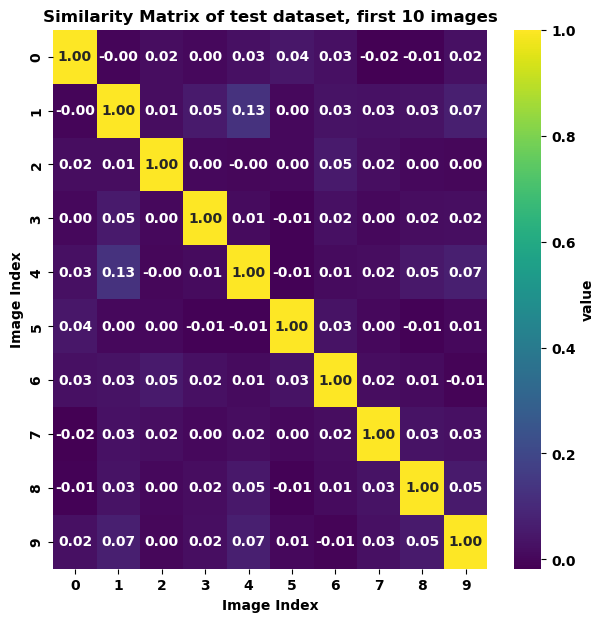

In [17]:
feature_map = cosine_similarity(vlad_vectors, vlad_vectors)
plot_and_save_heatmap(feature_map[:10, :10], title="Similarity Matrix of test dataset, first 10 images", x_label="Image Index", y_label="Image Index")

In [18]:
results = cluster_images_and_generate_statistics(
    features=feature_map,        # The subset corresponding to val+test
    true_labels=np.array(dataset.labels), # The true labels
    n_clusters=num_classes,
    method='spectral'
)
print(f"Clustering with Spectral Clustering into {num_classes} clusters:")
print("RI:", results["ri"])
print("ARI:", results["ari"])
print("NMI:", results["nmi"])

C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Clustering with Spectral Clustering into 102 clusters:
RI: 0.9776894671551799
ARI: 0.19485484137838632
NMI: 0.4478172825777498


## **4. Conclusion**

We've demonstrated:
- How to cluster images directly on deep-based VLAD vectors.
- How to compute ARI and NMI for objective evaluation.

For VLAD, clustering on the similarity matrix performs significantly better than clustering on the vectors themselves.
